In [1]:
# Import packages & libraries
import os # Interoperable file paths
import pathlib # Find the home folder
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files; stream zipped data from the internet like it was a file
from glob import glob # Import library to find files by pattern

import cartopy.crs as ccrs # CRSs
import earthaccess # Access NASA data from the cloud
import geopandas as gpd # Work with vector data
import hvplot.pandas # Interactive plots of vector data
import hvplot.xarray # Interactive raster
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import numpy as np # Unpack bit-wise Fmask
import pandas as pd # Group and aggregate
import regionmask # Convert shapefile to mask
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
from rioxarray.merge import merge_arrays # Merge rasters
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import xarray as xr # Adjust images
from xrspatial import zonal_stats # Calculate zonal statistics

c:\Users\riede\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Create data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'bld-co-redlining'
)

os.makedirs(data_dir, exist_ok=True)

data_dir

'C:\\Users\\riede\\earth-analytics\\data\\bld-co-redlining'

c:\Users\riede\miniconda3\envs\earth-analytics-python\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\riede\earth-analytics\data\bld-co-redlining\mappinginequalityboulder\redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<Axes: >

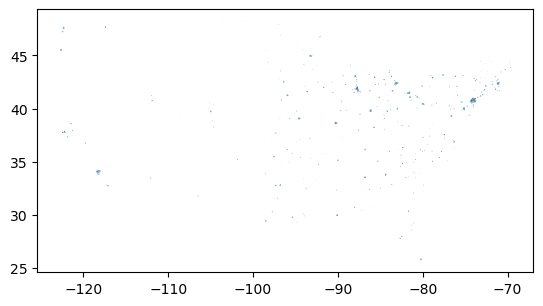

In [3]:
# Define and download redlining data
redlining_url = (
    "https://dsl.richmond.edu/panorama/redlining/static"
    "/mappinginequality.gpkg"
)

redlining_dir = os.path.join(
    data_dir,
    'mappinginequalityboulder'
)

os.makedirs(redlining_dir, exist_ok=True)

redlining_path = os.path.join(
    redlining_dir,
    'redlining.shp'
)

# Only download once
if not os.path.exists(redlining_path):
    redlining_gdf = gpd.read_file(redlining_url)
    redlining_gdf.to_file(redlining_path)

# Load from file
redlining_gdf = gpd.read_file(redlining_path)

# Check the data
redlining_gdf.plot()

In [4]:
#Select rows from redlining_gdf only for where Boulder is the city
bld_redlining_gdf = redlining_gdf[redlining_gdf.city=="Boulder"]

In [5]:
#Plot the bld_redlining_gdf with the EsriImagery and dissolve the regions
bld_redlining_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    fill_color=None, line_color='pink', line_width=4,
    title='Map Boulder, Colorado with Outline of Redlined Areas',
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

# Define necessary functions

In [6]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    #connect to the raster image
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()
    
    # Get the study bounds
    bounds = (
      bounds_gdf
      .to_crs(da.rio.crs)
      .total_bounds
    )

    # Crop
    cropped_da = da.rio.clip_box(*bounds)

    return cropped_da

#process_image(boulder_files[8], bld_redlining_gdf)

In [7]:
def process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    # Open fmask file
    fmask_da = process_image(cloud_uri, bounds_gdf)

    # Unpack the cloud mask bits
    cloud_bits = (
    np.unpackbits(
        (
            # Get the cloud mask as an array by just getting the values so the numpy function can work with it...
            fmask_da.values
            # ... of 8-bit integers
            .astype('uint8')
            # With an extra axis to unpack the bits into, kind of like we're adding a enw dimension, it will include our unpacked 8 bit fmask encoded number
            [:, :, np.newaxis]
        ), 
        # List the least significant bit first to match the user guide; least significant bit is usually last with how we normally write numbers,
        # but because the fmask userguide has the least significant bit first, we need to flip it around. around 1 hr 15 mins in Elsa's video
        bitorder='little',
        # Expand the array in a new dimension
        axis=-1)
    )

    cloud_mask = np.sum(
        # Select bits: everything in x dimension, everything in y dimension, and only the bit layers we want (1, 2, 3, and 5)
        cloud_bits[:,:,bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    # Check if any of bits are true
    ) == 0

    return cloud_mask

# #load in green da with previous function to test
# green_da = process_image(boulder_files[8], bld_redlining_gdf)

# # found cloud_uri by going back to notebook 91, looking at denver_files, and seeing that the Fmask file was the last one, or -1 by indexing
# # found bits_to_mask from notebook 32's bits_to_mask in cell 6
# boulder_cloud_mask = process_cloud_mask(
#     boulder_files[7],
#     bld_redlining_gdf,
#     [1, 2, 3, 5])

# green_da.where(boulder_cloud_mask).plot()

# Get multispectral data from earthaccess

In [8]:
# Log in to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [9]:
# Search earthaccess for a clear day in Boulder, CO
boulder_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(bld_redlining_gdf.total_bounds),
    temporal=("2022-07-01", "2022-07-02")
)
boulder_results

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.57693023, 'Latitude': 39.66017406}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.2819814, 'Latitude': 40.65024197}, {'Longitude': -105.57693023, 'Latitude': 39.66017406}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-01T17:37:32.646Z', 'EndingDateTime': '2022-07-01T17:37:56.533Z'}}
 Size(MB): 83.11219596862793
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.SAA.tif', 'https://dat

In [10]:
# Access Boulder, CO HLS data
boulder_files = earthaccess.open(boulder_results)
boulder_files

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B10.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.SAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B07.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B11.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.VAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

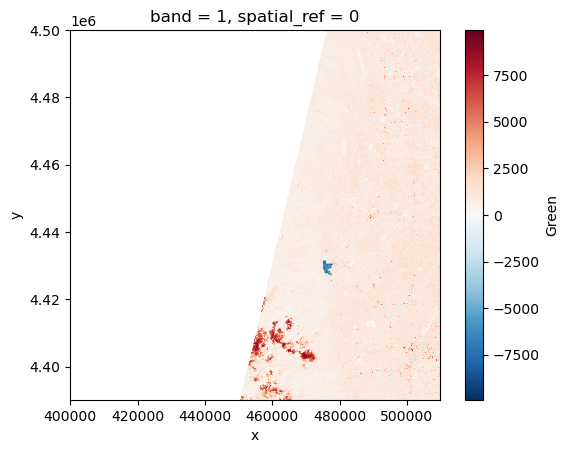

In [ ]:
# Import one tile of green data, which is the B03 file
green_da = rxr.open_rasterio(boulder_files[5], mask_and_scale=True).squeeze()
# display(green_da)
green_da.plot()

#bld first b/c vector data is a lot smaller than raster data and there's more data pts in the raster than in the vector
#x and y axes are meter distances, probably in UTM
bld_redlining_gdf.to_crs(green_da.rio.crs).plot(ax = plt.gca())

<xarray.DataArray (y: 3660, x: 3660)> Size: 27MB
[13395600 values with dtype=int16]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes: (12/36)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    ...                        ...
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       399960
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_16.1.0
    AREA_OR_POINT:             Area
    _FillValue:                -9999

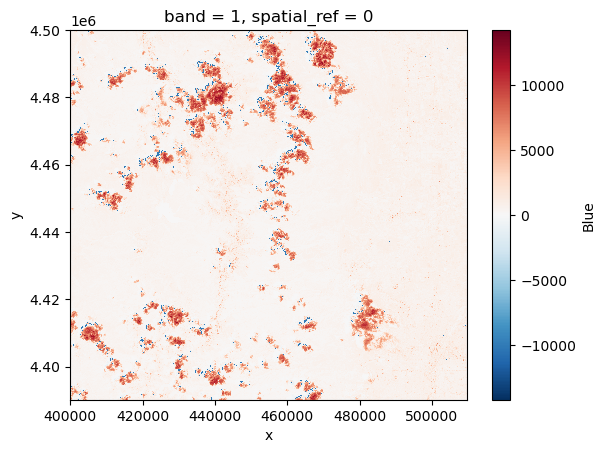

In [ ]:
# Import one tile of blue data, which is the B02 file
blue_da = rxr.open_rasterio(boulder_files[19]).squeeze()
display(blue_da)
blue_da.plot()

# Get metadata with regular expressions

In [ ]:
# Find all attributes of the boulder_files
dir(boulder_files[5])

['DEFAULT_BLOCK_SIZE',
 '__abstractmethods__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_abc_impl',
 '_checkClosed',
 '_checkReadable',
 '_checkSeekable',
 '_checkWritable',
 '_details',
 '_fetch_range',
 '_initiate_upload',
 '_upload_chunk',
 'close',
 'closed',
 'commit',
 'details',
 'discard',
 'f',
 'fileno',
 'flush',
 'full_name',
 'granule',
 'info',
 'isatty',
 'loc',
 'read',
 'readable',
 'readinto',
 'readinto1',
 'readline',
 'readlines',
 'readuntil',
 'seek',
 'seekable',
 'tell',
 'truncate',
 'writable',
 'write',
 'writelines']

In [ ]:
#full name attribute will give us what we want, just a string instead of the result from just boulder_files[8]
#add full_name to uri_re code cell below
boulder_files[8].full_name

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.VZA.tif'

In [ ]:
# Compile a regular expression to search for metadata
# the r indicates this is a raw string and highlights all escaped characters (the dots), limits our need to escape special characters
uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\."
    r"(?P<band_id>.+)\.tif"
)

#this yields a dictionary with the tile id, date, and band id
# the date is the 182 day of 2022
uri_re.search(boulder_files[8].full_name).groupdict()

{'tile_id': 'T13TDE', 'date': '2022182', 'band_id': 'VZA'}

In [ ]:
# Compile a regular expression to search for metadata
# the r indicates this is a raw string and highlights all escaped characters (the dots), limits our need to escape special characters
uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\."
    r"(?P<band_id>.+)\.tif"
)

# Find all the metadata in the file name
# this is list comprehension and this should give us a list of dictionaries that has the metadata (tile id, date, and band id) which we can use to make a dataframe
uri_groups = [
    uri_re.search(boulder_file.full_name).groupdict()
    for boulder_file in boulder_files]

# Create a DataFrame with the metadata
raster_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
raster_df['file'] = boulder_files

# Check the results
raster_df

,tile_id,date,band_id,file
0,T13TDE,2022182,B10,"<File-like object HTTPFileSystem, https://data..."
1,T13TDE,2022182,SAA,"<File-like object HTTPFileSystem, https://data..."
2,T13TDE,2022182,B07,"<File-like object HTTPFileSystem, https://data..."
3,T13TDE,2022182,B11,"<File-like object HTTPFileSystem, https://data..."
4,T13TDE,2022182,VAA,"<File-like object HTTPFileSystem, https://data..."
...,...,...,...,...
3145,T13TDE,2024315,B07,"<File-like object HTTPFileSystem, https://data..."
3146,T13TDE,2024315,B05,"<File-like object HTTPFileSystem, https://data..."
3147,T13TDE,2024315,Fmask,"<File-like object HTTPFileSystem, https://data..."
3148,T13TDE,2024315,B11,"<File-like object HTTPFileSystem, https://data..."


# Run for loops with our functions

In [ ]:
# Labels for each band to process
bands = {
    'B02': 'blue',
    'B03': 'green',
    'B04': 'red',
    'B05': 'nir'
}
# Initialize structure for saving images
# creating a dictionary with the band name with an empty list to accumulate results 
# band name will eventually save an image for each tile id
# bands.values will get the values (red, green, blue, or nir), from our bands dictionary above
boulder_das = {band_name: [] for band_name in bands.values()}
print(boulder_das)
# print('Loading...')
# double loop to group things by tile ID and then by band id and then we need to save the images together for each band
# grouping raster_df by tile id to go through each of the 210 tiles and then we should see for each tile, all 15 bands in the data frame
for tile_id, tile_df in raster_df.groupby('tile_id'):
    print(tile_id)
    # Load the cloud mask
    #in tile_df, select where the band_id equals fmask and just work on the file column entry. .values[0] gets rid of the array around the values that is printed automatically with the .file
    fmask_file = tile_df[tile_df.band_id=='Fmask'].file.values[0]
    cloud_mask = process_cloud_mask(
        fmask_file,
        bld_redlining_gdf,
        [1, 2, 3, 4])

    for band_id, row in tile_df.groupby('band_id'):
        if band_id in bands:
            band_name = bands[band_id]
            print(band_id, band_name)
            # Process band
            # this will give us the file out of the row
            band_da = process_image(
                row.file.values[0],
                bld_redlining_gdf)

            # Mask band, saving to the same variable as above b/c we're in the same cell and same loop
            band_masked_da = band_da.where(cloud_mask)
            
            # Store the resulting DataArray for later
            # this is our structure for saving images. going to save under the band name and append it to the empty list.
            boulder_das[band_name].append(band_masked_da)

    # Adding a break earlier on in our testing so it only runs once to help with debugging
    # break
    print('Done.')

{'blue': [], 'green': [], 'red': [], 'nir': []}
T13TDE
B02 blue
B03 green
B04 red
B05 nir
Done.


In [ ]:
boulder_das

{'blue': [<xarray.DataArray (y: 140, x: 102)> Size: 57kB
  array([[ 731.,  616.,  517., ...,  695.,  418.,  831.],
         [ 749.,  705.,  698., ..., 1215.,  460., 1050.],
         [ 741.,  635.,  610., ..., 1368.,  555.,  956.],
         ...,
         [ 212.,  169.,  211., ...,  538.,  463.,  552.],
         [ 214.,  197.,  317., ...,  551.,  564.,  536.],
         [ 218.,  363.,  539., ...,  531.,  540.,  510.]], dtype=float32)
  Coordinates:
      band         int64 8B 1
    * x            (x) float64 816B 4.749e+05 4.75e+05 ... 4.779e+05 4.78e+05
    * y            (y) float64 1kB 4.432e+06 4.431e+06 ... 4.427e+06 4.427e+06
      spatial_ref  int64 8B 0
  Attributes: (12/33)
      ACCODE:                    Lasrc; Lasrc
      arop_ave_xshift(meters):   0, 0
      arop_ave_yshift(meters):   0, 0
      arop_ncp:                  0, 0
      arop_rmse(meters):         0, 0
      arop_s2_refimg:            NONE
      ...                        ...
      TIRS_SSM_MODEL:            PRELI

In [ ]:
boulder_das['green'].plot(cmap='Greens', robust=True)

AttributeError: 'list' object has no attribute 'plot'